<a href="https://colab.research.google.com/github/Rezaparsazadeh/co2/blob/main/CCS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import glob
import cv2
import os
import locale
import seaborn as sns
from datetime import timedelta, datetime
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import plotly.graph_objects as go


In [2]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 26.1 MB/s 


In [18]:
from kerastuner.tuners import RandomSearch
import kerastuner as kt

In [19]:
df=pd.read_csv(r"Data.csv")


In [20]:
df

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),CO2 Excess Sorption (cm3/gr)
0,1.66,1.42,50,0.4413,0.0468
1,1.66,1.42,50,0.9308,0.0842
2,1.66,1.42,50,1.4617,0.1186
3,1.66,1.42,50,2.8337,0.2246
4,1.66,1.42,50,5.7158,0.3682
...,...,...,...,...,...
1195,4.76,1.50,70,2.2100,1.4600
1196,4.76,1.50,70,4.2800,1.9500
1197,4.76,1.50,70,6.2100,2.1700
1198,4.76,1.50,70,8.6700,2.2600


In [21]:
df.head()

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),CO2 Excess Sorption (cm3/gr)
0,1.66,1.42,50,0.4413,0.0468
1,1.66,1.42,50,0.9308,0.0842
2,1.66,1.42,50,1.4617,0.1186
3,1.66,1.42,50,2.8337,0.2246
4,1.66,1.42,50,5.7158,0.3682


In [22]:
df.shape

(1200, 5)

In [23]:
import matplotlib.pyplot as plt

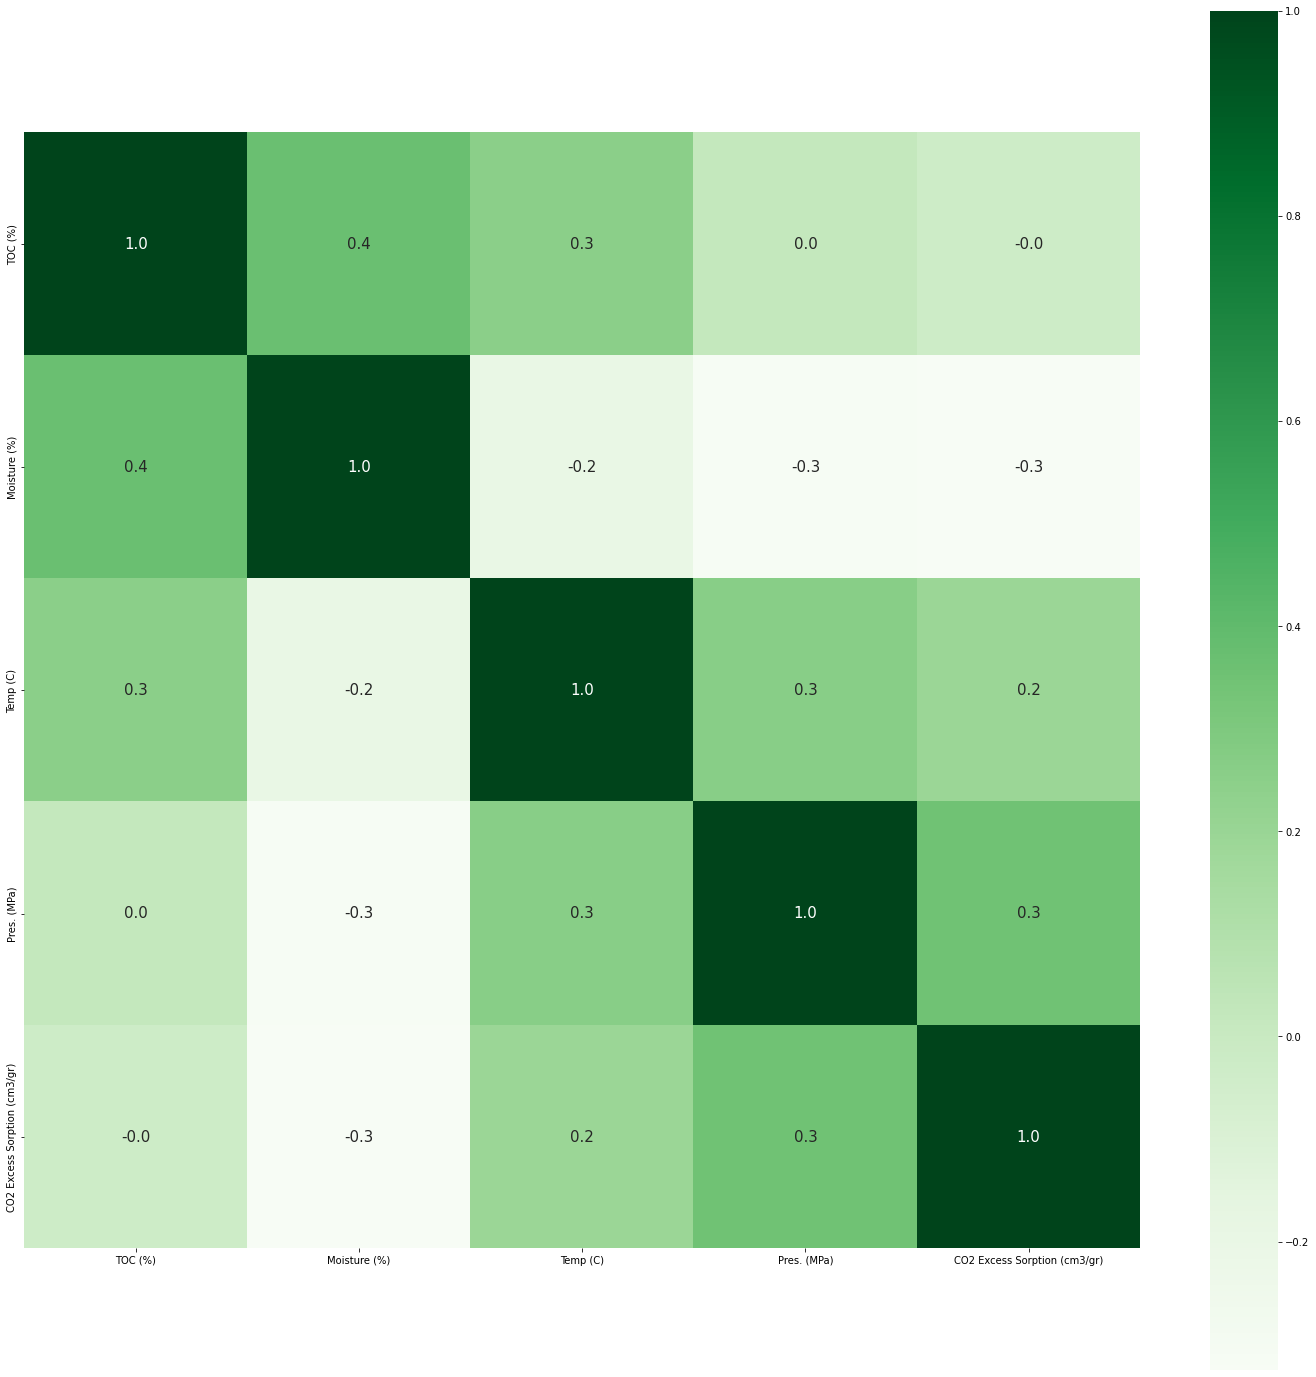

In [24]:
corr=df.corr()
plt.figure(figsize=(25,25))
sns.heatmap(corr , cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

In [25]:
df.columns

Index(['TOC (%)', 'Moisture (%)', 'Temp (C)', 'Pres. (MPa)',
       'CO2 Excess Sorption (cm3/gr)'],
      dtype='object')

In [26]:
df.dtypes

TOC (%)                         float64
Moisture (%)                    float64
Temp (C)                          int64
Pres. (MPa)                     float64
CO2 Excess Sorption (cm3/gr)    float64
dtype: object

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TOC (%)                       1200 non-null   float64
 1   Moisture (%)                  1200 non-null   float64
 2   Temp (C)                      1200 non-null   int64  
 3   Pres. (MPa)                   1200 non-null   float64
 4   CO2 Excess Sorption (cm3/gr)  1200 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 47.0 KB


In [28]:
df.describe()

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),CO2 Excess Sorption (cm3/gr)
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,11.946637,2.495300,48.523333,9.969668,1.260853
std,21.084400,2.050286,19.675333,7.214140,1.260792
min,0.090000,0.200000,30.000000,0.164000,0.001600
25%,1.700000,0.680000,30.000000,5.233850,0.300000
50%,5.150000,1.660000,45.000000,7.018250,0.695720
75%,10.940000,4.000000,60.000000,14.900250,1.720940
max,88.500000,10.970000,130.000000,27.861700,5.360000


In [30]:
y=df['CO2 Excess Sorption (cm3/gr)']

In [31]:
y

0       0.0468
1       0.0842
2       0.1186
3       0.2246
4       0.3682
         ...  
1195    1.4600
1196    1.9500
1197    2.1700
1198    2.2600
1199    2.3000
Name: CO2 Excess Sorption (cm3/gr), Length: 1200, dtype: float64

In [32]:
X = df[['TOC (%)','Temp (C)','Moisture (%)','Pres. (MPa)',]].values

In [33]:
X

array([[ 1.66  , 50.    ,  1.42  ,  0.4413],
       [ 1.66  , 50.    ,  1.42  ,  0.9308],
       [ 1.66  , 50.    ,  1.42  ,  1.4617],
       ...,
       [ 4.76  , 70.    ,  1.5   ,  6.21  ],
       [ 4.76  , 70.    ,  1.5   ,  8.67  ],
       [ 4.76  , 70.    ,  1.5   , 10.94  ]])

In [34]:
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.20,random_state=26)

In [35]:
X_test

array([[ 62.2       ,  61.        ,   6.4       ,   7.91      ],
       [  3.98      ,  45.        ,   0.25      ,  18.012     ],
       [ 10.94      ,  70.        ,   2.65      ,  13.84997887],
       [  0.45      ,  80.        ,   0.61      ,   1.4962    ],
       [  3.46      ,  30.        ,   5.51      ,   6.        ],
       [  1.72      ,  30.        ,   2.62      ,   6.        ],
       [ 10.94      ,  45.        ,   0.39      ,  14.313     ],
       [  5.15      ,  30.        ,   6.94      ,   6.1761    ],
       [  5.79      ,  45.        ,   0.41      ,   5.102     ],
       [  5.41      ,  45.        ,   0.3       ,   3.473     ],
       [  5.41      ,  45.        ,   1.81      ,  20.902     ],
       [ 10.94      , 100.        ,   2.65      ,  15.38228783],
       [  5.7       ,  38.        ,   2.8       ,  21.7095    ],
       [  1.91      ,  30.        ,   3.63      ,   6.        ],
       [ 10.94      , 130.        ,   2.65      ,  15.5253222 ],
       [  1.81      ,  30

In [36]:
X_train

array([[  4.76      ,  60.        ,   1.5       ,   8.67      ],
       [ 10.94      ,  45.        ,   0.39      ,   4.205     ],
       [  1.51      ,  45.        ,   0.74      ,   5.448     ],
       ...,
       [  6.11      ,  64.        ,   1.5       ,  20.22      ],
       [  4.05      ,  57.        ,   1.5       ,   9.57      ],
       [ 10.94      , 130.        ,   2.65      ,  19.01113305]])

In [37]:
y_train

1191    2.590000
692     3.051496
513     0.152777
489     1.329100
580     0.461797
          ...   
941     3.991722
160     0.265200
1101    4.780000
1126    2.950000
821     2.304704
Name: CO2 Excess Sorption (cm3/gr), Length: 960, dtype: float64

In [38]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train[:, :] = sc.fit_transform(X_train[:, :])
X_test[:, :] = sc.transform(X_test[:, :])

In [39]:
X_train

array([[0.05282208, 0.3       , 0.12070566, 0.30710131],
       [0.12272367, 0.15      , 0.0176416 , 0.14589659],
       [0.01606153, 0.15      , 0.05013928, 0.19077396],
       ...,
       [0.06809184, 0.34      , 0.12070566, 0.72410345],
       [0.04479131, 0.27      , 0.12070566, 0.33959498],
       [0.12272367, 1.        , 0.22748375, 0.68045842]])

In [40]:
print(X_train.shape)
print(X_test.shape)

(960, 4)
(240, 4)


In [115]:
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf
import kerastuner as kt
msle = MeanSquaredLogarithmicError()
def build_model(hp):
  model = tf.keras.Sequential()
  


In [130]:
from kerastuner import HyperModel


class ANNHyperModel(HyperModel):
    
    def build(self, hp):
      model = tf.keras.Sequential()
      # Tune the number of units in the first Dense layer
      # Choose an optimal value between 8-2048
      hp_units1 = hp.Int('units1', min_value=8, max_value=2048, step=32)
      hp_units2 = hp.Int('units2', min_value=8, max_value=2048, step=32)
      hp_units3 = hp.Int('units3', min_value=8, max_value=2048, step=32)
      hp_units4 = hp.Int('units3', min_value=8, max_value=2048, step=32)
      hp_units5 = hp.Int('units3', min_value=8, max_value=2048, step=32)
      hp_units6 = hp.Int('units3', min_value=8, max_value=2048, step=32)
      

      model.add(Dense(units=hp_units1, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units4, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units5, activation='relu'))
      model.add(tf.keras.layers.Dense(units=hp_units6, activation='relu'))
     
      
      model.add(Dense(1, kernel_initializer='normal', activation='linear'))

      # Tune the learning rate for the optimizer
      # Choose an optimal value from 0.01, 0.001, or 0.0001
      hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

      model.compile(
          optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
          loss=msle,
          metrics=[msle]
      )

      return model

hypermodel = ANNHyperModel()

tuner = kt.Hyperband(
    hypermodel,
    objective='val_mean_squared_logarithmic_error',
    max_epochs=30,
    factor=3,
    directory='keras_tuner_dir',
    project_name='keras_tuner_demo2'
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2)

INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir/keras_tuner_demo2/oracle.json


INFO:tensorflow:Reloading Oracle from existing project keras_tuner_dir/keras_tuner_demo2/oracle.json


INFO:tensorflow:Reloading Tuner from keras_tuner_dir/keras_tuner_demo2/tuner0.json


INFO:tensorflow:Reloading Tuner from keras_tuner_dir/keras_tuner_demo2/tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [131]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate']:
  print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))
 


units1 520
units2 584
units3 744
learning_rate 0.001


In [132]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)


In [133]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (960, 520)                2600      
                                                                 
 dense_1 (Dense)             (960, 584)                304264    
                                                                 
 dense_2 (Dense)             (960, 744)                435240    
                                                                 
 dense_3 (Dense)             (960, 744)                554280    
                                                                 
 dense_4 (Dense)             (960, 744)                554280    
                                                                 
 dense_5 (Dense)             (960, 744)                554280    
                                                                 
 dense_6 (Dense)             (960, 1)                  7

In [143]:
best_model.fit(
    X_train, 
    y_train,
    epochs=30,
    batch_size=64)

Epoch 1/30
15/15 [==============================] - 0s 4ms/step - loss: 0.0082 - mean_squared_logarithmic_error: 0.0082
Epoch 2/30
15/15 [==============================] - 0s 5ms/step - loss: 0.0080 - mean_squared_logarithmic_error: 0.0080
Epoch 3/30
15/15 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_logarithmic_error: 0.0081
Epoch 4/30
15/15 [==============================] - 0s 6ms/step - loss: 0.0111 - mean_squared_logarithmic_error: 0.0111
Epoch 5/30
15/15 [==============================] - 0s 6ms/step - loss: 0.0127 - mean_squared_logarithmic_error: 0.0127
Epoch 6/30
15/15 [==============================] - 0s 5ms/step - loss: 0.0108 - mean_squared_logarithmic_error: 0.0108
Epoch 7/30
15/15 [==============================] - 0s 6ms/step - loss: 0.0099 - mean_squared_logarithmic_error: 0.0099
Epoch 8/30
15/15 [==============================] - 0s 6ms/step - loss: 0.0091 - mean_squared_logarithmic_error: 0.0091
Epoch 9/30
15/15 [======================

In [144]:
# mean squared logarithmic error
msle(y_test, best_model.predict(X_test)).numpy()



0.4978825

In [145]:
predictions=best_model.predict(X_test)

In [146]:
predictions

array([[0.26358366],
       [0.6675408 ],
       [3.294592  ],
       [0.03388253],
       [0.6337643 ],
       [0.30722725],
       [3.6120884 ],
       [0.7962623 ],
       [1.4719864 ],
       [1.332327  ],
       [1.0075943 ],
       [2.3786418 ],
       [1.3907931 ],
       [0.36909083],
       [2.1212788 ],
       [0.34068653],
       [1.6355909 ],
       [0.03721152],
       [4.282252  ],
       [0.64183426],
       [3.192845  ],
       [0.19065697],
       [0.09976424],
       [1.4117388 ],
       [0.4695598 ],
       [0.4579586 ],
       [0.338712  ],
       [0.13937591],
       [0.94848305],
       [1.5906602 ],
       [3.1478565 ],
       [0.21982549],
       [0.19786946],
       [5.0800314 ],
       [0.37059638],
       [0.0168345 ],
       [2.8092124 ],
       [0.6936282 ],
       [0.03528132],
       [0.20662977],
       [0.75789976],
       [0.47258553],
       [0.6449848 ],
       [4.2585063 ],
       [0.22313975],
       [2.0380433 ],
       [1.2191968 ],
       [1.180

In [147]:
y_test

970    0.238400
568    0.746137
766    3.383213
110    0.040600
350    0.900000
         ...   
936    3.978579
639    1.314027
385    0.430000
761    3.057582
573    0.696059
Name: CO2 Excess Sorption (cm3/gr), Length: 240, dtype: float64

In [148]:
from sklearn import metrics

In [149]:
print('Training , Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Training , Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Training , Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Training , Mean Absolute Error: 0.10775206043839397
Training , Mean Squared Error: 0.02869294987631652
Training , Root Mean Squared Error: 0.16938993440082714


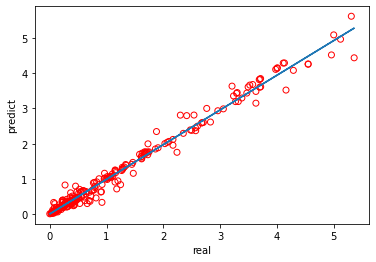

In [150]:
ig, ax = plt.subplots()
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(y_test,predictions, 1)
plt.plot(y_test, b + m * y_test, '-')
ax.scatter(y_test,predictions,color='r',facecolors='none')
plt.xlabel('real')
plt.ylabel('predict')
plt.show()

In [151]:
R=print(metrics.r2_score(y_test, predictions)) 

0.9827441830632769
